In [17]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, roc_curve, roc_auc_score, auc
import glob
import matplotlib.pyplot as plt
from time import strftime

In [3]:
X_signal = np.load('data/signal.npz')['X'][:,:9]
y_signal = np.ones(X_signal.shape[0])

In [4]:
def get_bkg_features(sets_of_npzs, weights, n_target_events=10000):
    """
    Gets a combined, weighted combination of events
    """
    weights /= np.sum(weights) # normalize
    n_events_per_set = (weights * n_target_events).astype(np.int32)

    print(f'n_events per set: {n_events_per_set}')

    X_combined = []
    for n_events, npzs in zip(n_events_per_set, sets_of_npzs):
        n_events_todo = n_events
        for npz in npzs:
            X = np.load(npz)['X'][:,:9]
            n_events_this_npz = X.shape[0]
            if n_events_this_npz > n_events_todo:
                X = X[:n_events_todo]
            X_combined.append(X)
            n_events_todo -= X.shape[0]
            if n_events_todo == 0: break
        else:
            print(f'Warning: reached end of set of files with n_events_todo={n_events_todo}')

    X_final = np.vstack(X_combined)
    assert len(X_final.shape) == 2
    assert X_final.shape[1] == 9
    return X_final

In [5]:
labels = ['300to470', '470to600', '600to800', '800to1000', '1000to1400']
crosssections = [.1*6826.0, 552.6, 156.6, 26.32, 7.50]
sets_of_npzs = [ glob.iglob(f'data/bkg/*{l}*/*.npz') for l in labels ]
X_bkg = get_bkg_features(sets_of_npzs, crosssections)
y_bkg = np.zeros(X_bkg.shape[0])

n_events per set: [4788 3876 1098  184   52]


In [6]:
X = np.vstack((X_signal, X_bkg))
y = np.concatenate((y_signal, y_bkg)).astype(np.int8)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2)
y_train = y_train.astype(np.int8)
y_test = y_test.astype(np.int8)

In [7]:
y_train

array([0, 0, 1, ..., 0, 1, 0], dtype=int8)

In [8]:
model = xgb.XGBClassifier(
    eta=.03, scale_pos_weight=y.shape[0]/np.sum(y),
    max_depth=3,
    n_estimators=850,

    )
model.fit(X_train, y_train)

# NTrees=850
# MinNodeSize=2.5%
# MaxDepth=3
# BoostType=AdaBoost
# AdaBoostBeta=0.5
# UseBaggedBoost
# BaggedSampleFraction=0.5
# SeparationType=GiniIndex
# nCuts=20


/Users/klijnsma/miniconda3/envs/svj-bdt/lib/python3.9/site-packages/xgboost/sklearn.py:1146: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[15:50:47] WARNING: ../src/learner.cc:1095: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, eta=0.03, gamma=0,
              gpu_id=-1, importance_type='gain', interaction_constraints='',
              learning_rate=0.0299999993, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=850, n_jobs=12, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=4.693387513852974,
              subsample=1, tree_method='exact', validate_parameters=1,
              verbosity=None)

In [9]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)[:,1]
confusion_matrix(y_test, y_pred)

array([[1418,  595],
       [ 100,  428]])

Text(0, 0.5, 'Sig efficiency')

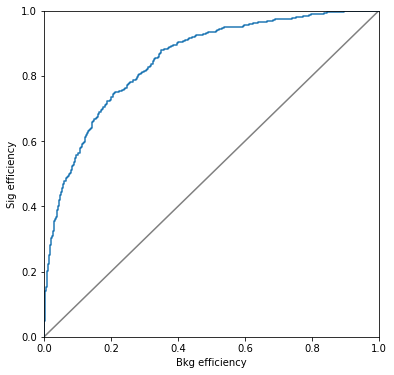

In [42]:
eff_bkg, eff_sig, cuts = roc_curve(y_test, y_prob)

fig = plt.figure(figsize=(6,6))
ax = fig.gca()
ax.plot([0,1], [0,1], c='gray')
ax.plot(eff_bkg, eff_sig)
ax.set_ylim(0., 1.)
ax.set_xlim(0., 1.)
ax.set_xlabel('Bkg efficiency')
ax.set_ylabel('Sig efficiency')

In [48]:
i_wp = np.argmax(eff_bkg >= .05)
print(f'eff_sig: {eff_sig[i_wp]:.3f}, bkg_eff: {eff_bkg[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

i_wp = np.argmax(eff_bkg >= .2)
print(f'eff_sig: {eff_sig[i_wp]:.3f}, bkg_eff: {eff_bkg[i_wp]:.3f}, cut: {cuts[i_wp]:.3f}')

eff_sig: 0.438, bkg_eff: 0.051, cut: 0.828
eff_sig: 0.733, bkg_eff: 0.201, cut: 0.596


In [21]:
model.save_model(strftime('svjbdt_%b%d.json'))

In [49]:
auc(eff_bkg, eff_sig)

0.84922812325942

In [12]:
y_prob_sig = y_prob[y_test == 1]
y_prob_bkg = y_prob[y_test == 0]

Text(0.5, 0, 'BDT score')

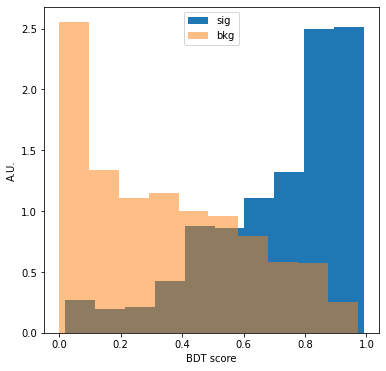

In [51]:
fig = plt.figure(figsize=(6,6))
ax = fig.gca()

ax.hist(y_prob_sig, label='sig', density=True)
ax.hist(y_prob_bkg, label='bkg', alpha=.5, density=True)
ax.legend()
ax.set_ylabel('A.U.')
ax.set_xlabel('BDT score')

In [137]:
corrmat = np.corrcoef(X.T)

In [138]:
corrmat.shape

(9, 9)

/var/folders/lv/lrgmjwhs3yqd4yv_bqfsmckw0000gp/T/ipykernel_61708/3519977219.py:5: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_xticklabels(['']+labels, rotation=90)
/var/folders/lv/lrgmjwhs3yqd4yv_bqfsmckw0000gp/T/ipykernel_61708/3519977219.py:6: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax.set_yticklabels(['']+labels)


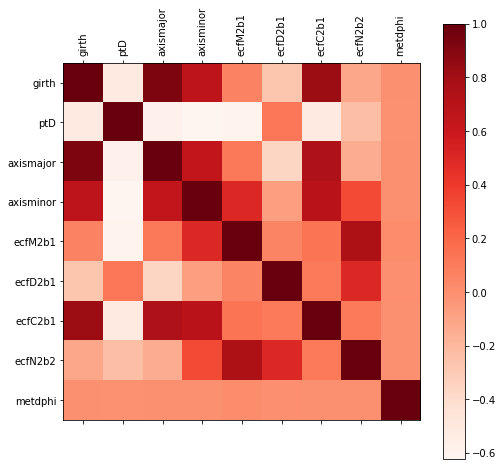

In [158]:
labels = ['girth', 'ptD', 'axismajor', 'axisminor', 'ecfM2b1', 'ecfD2b1', 'ecfC2b1', 'ecfN2b2', 'metdphi']
fig = plt.figure(figsize=(8,8))
ax = fig.gca()
mshow = ax.matshow(corrmat, cmap=plt.cm.Reds)
ax.set_xticklabels(['']+labels, rotation=90)
ax.set_yticklabels(['']+labels)

cbar = fig.colorbar(mshow)
cbar


In [18]:
# dir(plt.cm)

In [20]:
# plt.cm.Reds

## Check model IO

In [22]:
model2 = xgb.XGBClassifier()
model2.load_model('/Users/klijnsma/work/svj/bdt/svjbdt_Aug02.json')

In [25]:
model.predict_proba(X_test[:10])

array([[0.8479688 , 0.15203115],
       [0.3819521 , 0.6180479 ],
       [0.13827968, 0.8617203 ],
       [0.45705366, 0.54294634],
       [0.2996062 , 0.7003938 ],
       [0.03772777, 0.9622722 ],
       [0.13355088, 0.8664491 ],
       [0.52489877, 0.47510123],
       [0.9634757 , 0.03652427],
       [0.59360355, 0.40639645]], dtype=float32)

In [26]:
model2.predict_proba(X_test[:10])

array([[0.8479688 , 0.15203115],
       [0.3819521 , 0.6180479 ],
       [0.13827968, 0.8617203 ],
       [0.45705366, 0.54294634],
       [0.2996062 , 0.7003938 ],
       [0.03772777, 0.9622722 ],
       [0.13355088, 0.8664491 ],
       [0.52489877, 0.47510123],
       [0.9634757 , 0.03652427],
       [0.59360355, 0.40639645]], dtype=float32)